# Кластеризация
__Суммарное количество баллов: 10__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

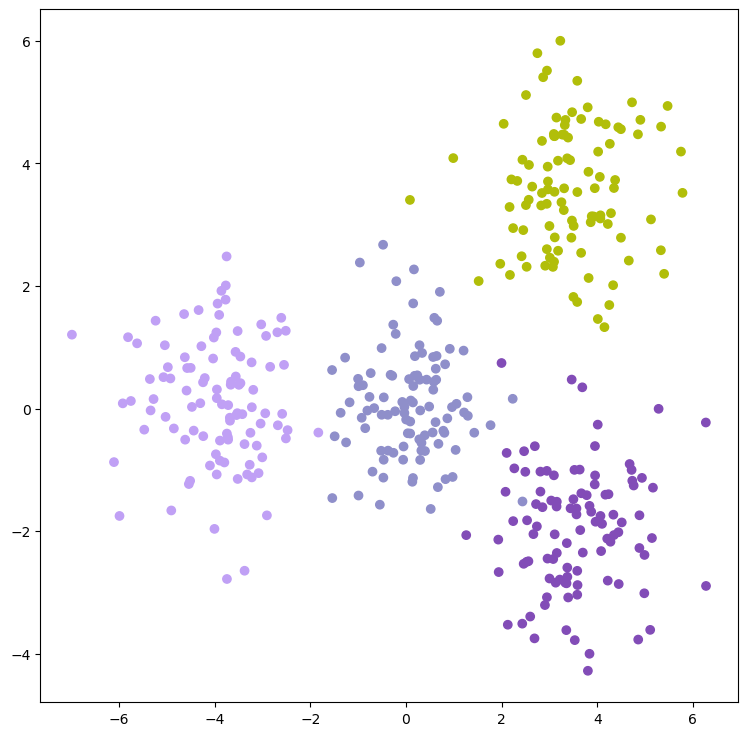

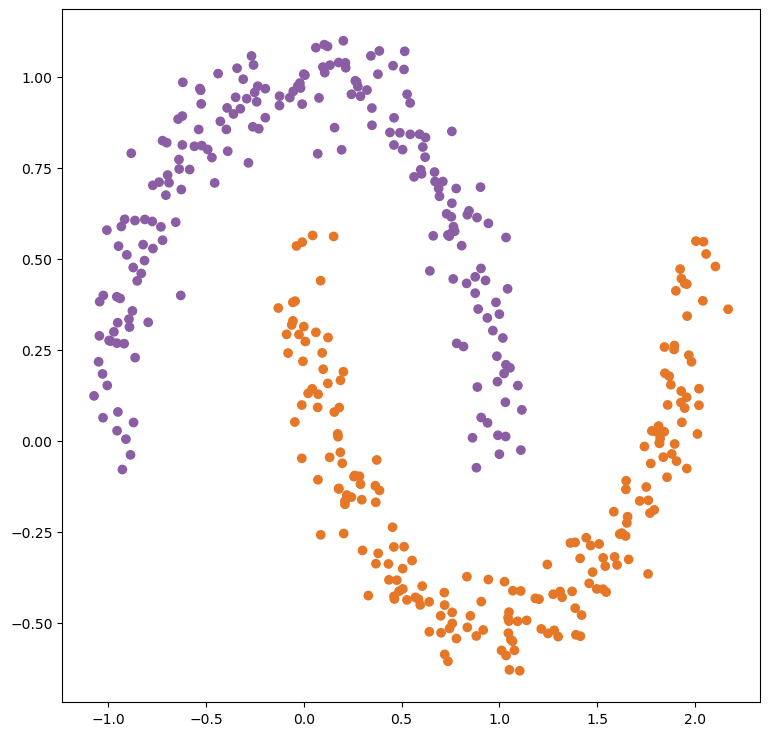

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [4]:
# Task 1

def dist(data, cent):
    distance = np.sum((np.array(cent) - data[:, None, :])**2, axis = 2)
    return distance
def kmeans_plus_plus(X, k, pdf_method = True):
    centers = []
    X = np.array(X)
    initial_index = np.random.choice(range(X.shape[0]), )
    centers.append(X[initial_index, :].tolist())    
    for i in range(k - 1):
        distance = dist(X, np.array(centers))
        
        if i == 0:
            pdf = distance/np.sum(distance)
            centroid_new = X[np.random.choice(range(X.shape[0]), replace = False, p = pdf.flatten())]
        else:
            dist_min = np.min(distance, axis = 1)
            if pdf_method == True:
                pdf = dist_min/np.sum(dist_min)
                centroid_new = X[np.random.choice(range(X.shape[0]), replace = False, p = pdf)]
            else:
                index_max = np.argmax(dist_min, axis = 0)
                centroid_new = X[index_max, :]
        centers.append(centroid_new.tolist())
        
    return np.array(centers)

class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None     
        
    # функция для инициализации кластеров    
    def initialize_clusters(self, X: np.array, zero_clusters = None):
        if self.init == "random":
            if zero_clusters is None:
                min_coord, max_coord = np.min(X, axis = 0), np.max(X, axis = 0)
                self.centroids = [random.uniform(min_coord, max_coord) for _ in range(self.n_clusters)]
            else:
                min_coord, max_coord = np.min(X, axis = 0), np.max(X, axis = 0)
                self.centroids[zero_clusters] = [random.uniform(min_coord, max_coord) for _ in range(self.centroids[zero_clusters])]
                
        if self.init == "sample":
            if zero_clusters is None:
                index = np.random.choice(X.shape[0], self.n_clusters, replace = False)
                self.centroids = X[index]
            else:
                index = np.random.choice(X.shape[0], len(zero_clusters), replace = False)
                self.centroids[zero_clusters] = X[index]
        if self.init == "k-means++":
            if zero_clusters is None:
                self.centroids = kmeans_plus_plus(X, self.n_clusters, pdf_method = True)
            else:
                for i in range(len(zero_clusters)):
                    distance = dist(X, np.array(self.centroids))
                    if i == 0:
                        pdf = distance/np.sum(distance)
                        centroid_new = X[np.random.choice(range(X.shape[0]), replace = False, p = pdf.flatten())]
                    else:
                        dist_min = np.min(distance, axis = 1)
                        if pdf_method == True:
                            pdf = dist_min/np.sum(dist_min)
                            centroid_new = X[np.random.choice(range(X.shape[0]), replace = False, p = pdf)]
                        else:
                            index_max = np.argmax(dist_min, axis = 0)
                            centroid_new = X[index_max, :]
                    self.centroids.append(centroid_new.tolist())
                    
        self.centroids = np.array(self.centroids)
            
                
    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        
        self.centroids = np.zeros((self.n_clusters, X.shape[-1]))
        self.initialize_clusters(X)
        
        for j in range(self.max_iter):
                dist = [[np.linalg.norm(c - x) for c in self.centroids] for x in X]
                centr_ids = np.argmin(dist, axis = 1)
                ids, counts = np.unique(centr_ids, return_counts = True)
                amount = np.zeros(self.n_clusters)
                
                for i, c in zip(ids, counts):
                    amount[i] = c
                new_centr = np.zeros(self.centroids.shape)
                for i, x in zip(centr_ids, X):
                    new_centr[i] += x
                new_centr[amount > 0] = (new_centr[amount > 0].T / amount[amount > 0]).T
                self.centroids = new_centr
                mask = [amount[i] == 0 for i in range(self.n_clusters)]
                if np.sum(mask) > 0:
                    self.initialize_clusters(X, mask)
        
    
    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        dist = [[np.linalg.norm(c - x) for c in self.centroids] for x in X]
        return np.argmin(dist, axis = 1)

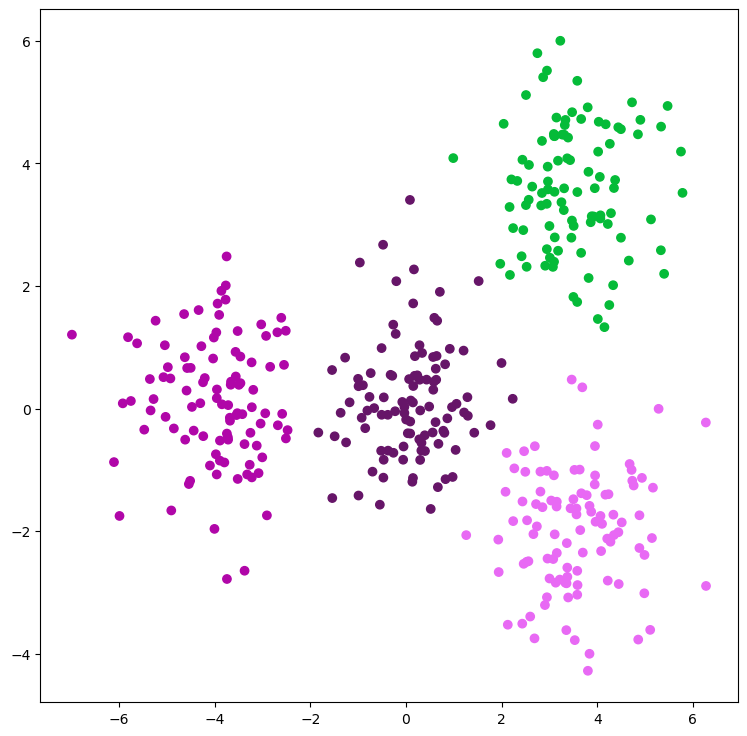

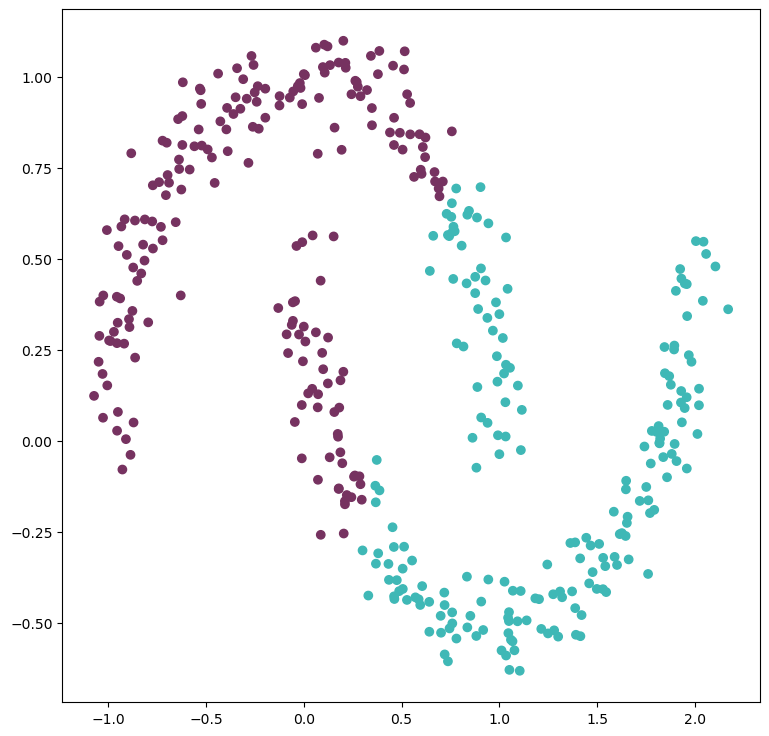

In [5]:
kmeans = KMeans(n_clusters=4, init = "k-means++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init = "k-means++")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (3 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [6]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.metric = metric
        self.leaf_size = leaf_size
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        # создаем kd-дерво
        tree = KDTree(X, self.leaf_size, self.metric)
        # запрос в дереве соседей в радиусе eps
        eps_neigh = tree.query_radius(X, self.eps)
        # выделяем core points
        cp = []
        for i in range(len(X)):
            if len(eps_neigh[i]) >= self.min_samples:
                cp.append(i)
        # список кластеров точек
        points_clusters = [-1] * len(X)
        # начинаем с класса 0
        number_cl = 0
        for j in cp:
            if points_clusters[j] == -1:
                p = deque()
                p.append(j)
                points_clusters[j] = number_cl
                while p:
                    i = p.popleft()
                    points_clusters[i] = number_cl
                    if len(eps_neigh[i]) >= self.min_samples:
                        for k in eps_neigh[i]:
                            if points_clusters[k] < number_cl:
                                points_clusters[k] = number_cl
                                p.append(k)
                
                number_cl += 1
        return points_clusters

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

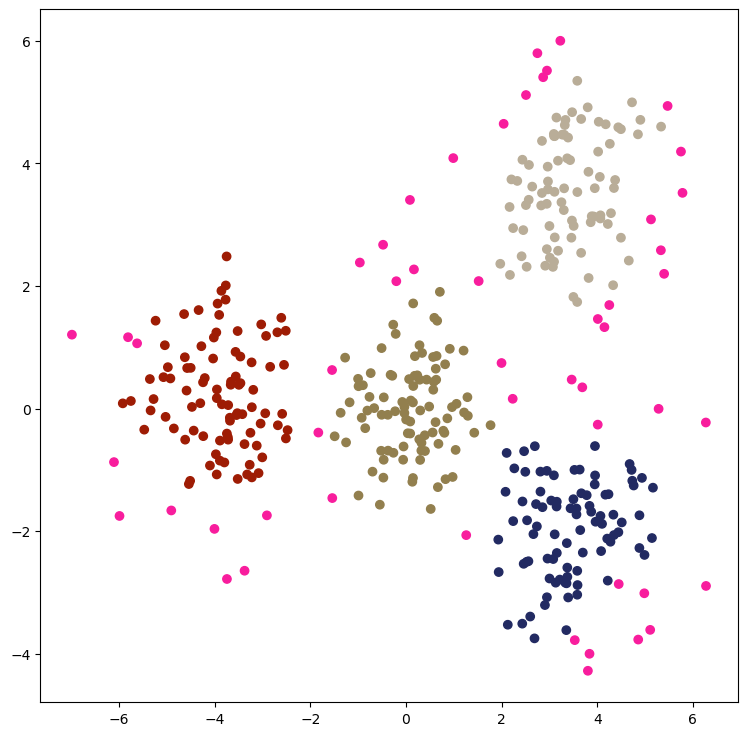

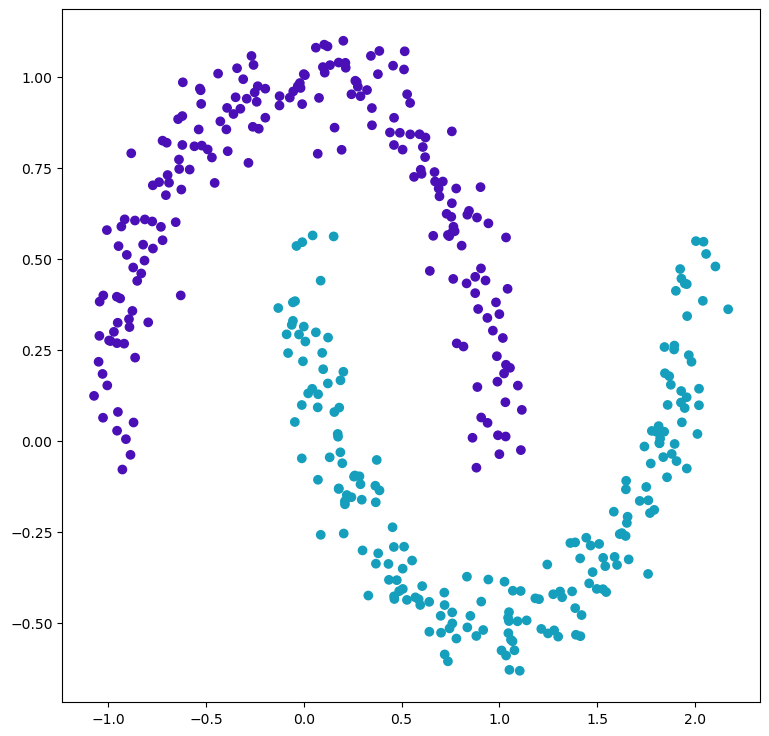

In [8]:
dbscan = DBScan(eps = 0.55)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps = 0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Дополнительно
Научимся кластеризовать цвета в изображении. Для начала используем OpenCV для того, чтобы считать изображение.

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [22]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) / 255.
    return image

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    image = cv2.cvtColor(np.float32(image * 255), cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

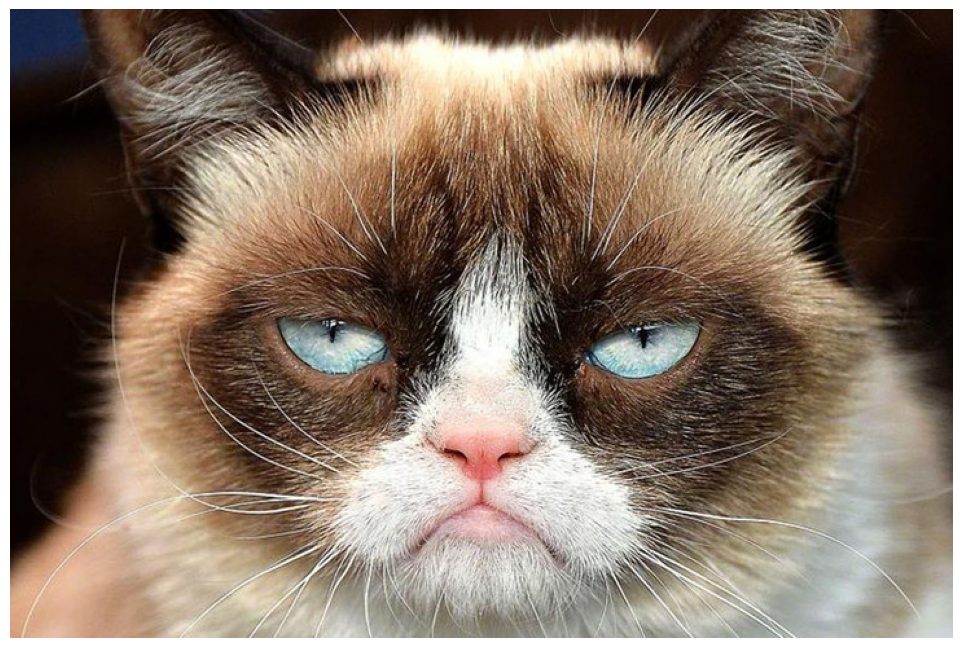

In [24]:
show_image(read_image("cat.jpeg"))

Теперь реализуем функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем применим ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [27]:
def clusterize_image(image, n_clusters=8, color_scheme="rgb", show_cluster_statisitcs = False):
    orig_image = image
    if color_scheme == "hsv":
        image = cv2.cvtColor((image * 255).astype('float32'), cv2.COLOR_RGB2HSV)
        image /= 255.
    shape = image.shape
    
    small = image[::4,::4,:]
    image = image.reshape((-1, shape[-1]))
    orig_image = orig_image.reshape((-1, shape[-1]))
    X = small.reshape((-1, shape[-1]))
    kmeans = KMeans(max_iter=16, n_clusters=n_clusters, init="k-means++")
    kmeans.fit(X)
    clusters = kmeans.predict(image)
    cluster_colors = kmeans.centroids

    recolored = np.array([cluster_colors[c] for c in clusters]).reshape(shape)
    if color_scheme == "hsv":
        recolored *= 255
        recolored = cv2.cvtColor(recolored.astype('float32'), cv2.COLOR_HSV2RGB) / 255.
    if show_cluster_statisitcs:
        clusters_statistics(orig_image, cluster_colors, clusters)
    return recolored.reshape(shape)

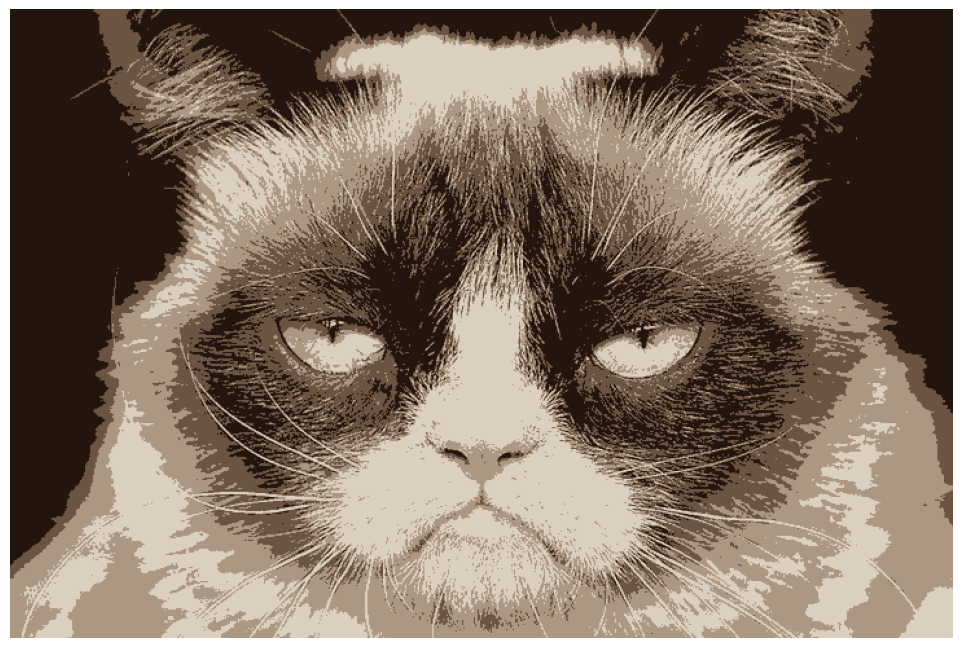

In [28]:
image = read_image("cat.jpeg")
result = clusterize_image(image, n_clusters=4)
show_image(result)

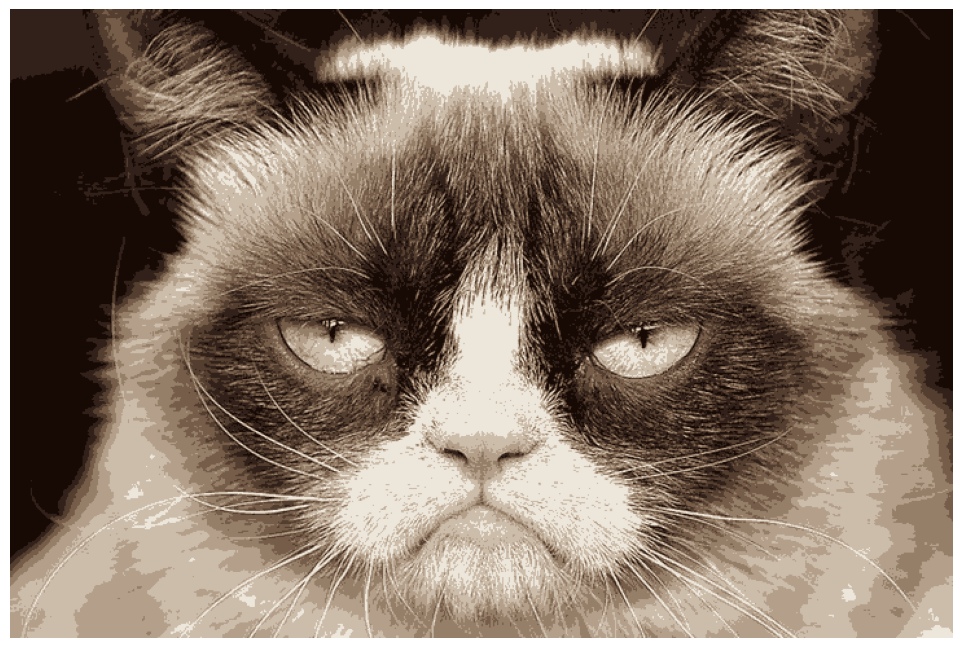

In [30]:
image = read_image("cat.jpeg")
result = clusterize_image(image, n_clusters=8)
show_image(result)

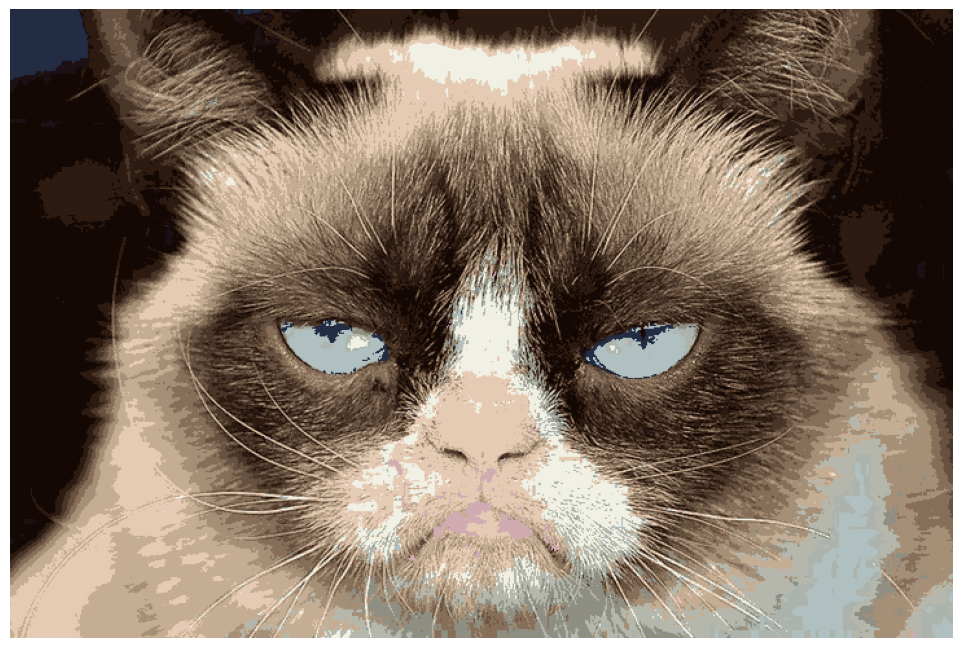

In [31]:
image = read_image("cat.jpeg")
result = clusterize_image(image, n_clusters=16, color_scheme = "hsv")
show_image(result)